In [1]:
#-*- coding: utf-8 -*-

In [1]:
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame as df

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv('C:/Users/chaeyoung/Desktop/경희대학교/공모전/K-water/데이터/하천데이터/river_final_no_na.csv', encoding = 'euc-kr')

# 이상치 제거

In [3]:
river = df

# 결측치 제거
river = river.dropna(axis=0)
np.shape(river)

Q1 = river.quantile(0.25)
Q3 = river.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

river_out = river[~((river.iloc[:,1:] < (Q1 - 1.5 * IQR)) |(river.iloc[:,1:] > (Q3 + 1.5 * IQR))).any(axis=1)]
river_out.shape

temp = river_out

ITEM_TEMP           13.700000
ITEM_PH              0.700000
ITEM_DOC             3.700000
ITEM_BOD             1.810092
ITEM_COD             3.700000
ITEM_TN              1.980000
MEAN_TEMP           15.700000
L_TEMP              16.900000
U_TEMP              15.400000
MAX_MOMENT_WIND      3.300000
MAX_MIN              2.100000
MEAN_WIND            1.100000
M_WIND_100         923.000000
MEAN_DEW            17.500000
L_REHU              26.000000
MEAN_MOIS           21.487857
MEAN_STPR           12.996525
MEAN_hPa            14.900000
U_hPa               12.724113
L_hPa               12.000000
MEAN_PRES           12.200000
MEAN_SUN             3.144942
SUM_SUN              6.300000
MEAN_LAND           18.100000
L_TEMP.1            18.100000
ITEM_SS              7.500000
ITEM_TP              0.063000
dtype: float64


In [4]:
temp.head()

,ITEM_TEMP,ITEM_PH,ITEM_DOC,ITEM_BOD,ITEM_COD,ITEM_TN,MEAN_TEMP,L_TEMP,U_TEMP,MAX_MOMENT_WIND,...,U_hPa,L_hPa,MEAN_PRES,MEAN_SUN,SUM_SUN,MEAN_LAND,L_TEMP.1,ITEM_SS,ITEM_TP,key
0,38.1,7.9,6.6,0.8,3.9,0.945,28.7,25.9,35.1,7.6,...,1000.0,996.5,998.2,13.8,11.0,33.1,24.2,1.4,0.130,2017.08.07울산
1,37.6,8.0,8.4,0.4,7.9,5.381,30.6,26.3,36.2,9.6,...,1011.1,1007.5,1009.5,13.9,12.3,36.8,23.1,9.0,0.092,2015.08.03울산
3,36.7,7.5,6.8,0.3,3.6,0.940,28.6,23.6,33.8,6.2,...,1006.2,1002.9,1004.4,13.9,12.9,35.2,21.4,1.6,0.121,2018.08.01울산
6,36.2,7.7,9.0,0.7,3.0,1.374,26.3,20.6,33.0,8.7,...,1009.5,1004.6,1007.1,14.5,12.5,32.8,18.9,4.0,0.018,2014.07.14안동
7,36.0,8.7,9.0,2.5,9.7,1.687,31.2,23.8,37.9,4.9,...,1007.5,1004.1,1006.1,14.0,10.8,39.2,21.5,5.0,0.025,2018.08.02구미


# 변수 스케일링

In [5]:
time = temp[['key']]
not_time = temp[['ITEM_TEMP', 'ITEM_PH', 'ITEM_DOC', 'ITEM_BOD', 'ITEM_COD', 'ITEM_TN',
 'MEAN_TEMP', 'L_TEMP', 'U_TEMP', 'MAX_MOMENT_WIND', 'MAX_MIN', 'MEAN_WIND', 'M_WIND_100',
 'MEAN_DEW', 'L_REHU', 'MEAN_MOIS', 'MEAN_STPR', 'MEAN_hPa', 'U_hPa', 'L_hPa', 'MEAN_PRES',
 'MEAN_SUN', 'SUM_SUN', 'MEAN_LAND', 'L_TEMP.1', 'ITEM_SS','ITEM_TP' ]]

In [6]:
not_time.head()

,ITEM_TEMP,ITEM_PH,ITEM_DOC,ITEM_BOD,ITEM_COD,ITEM_TN,MEAN_TEMP,L_TEMP,U_TEMP,MAX_MOMENT_WIND,...,MEAN_hPa,U_hPa,L_hPa,MEAN_PRES,MEAN_SUN,SUM_SUN,MEAN_LAND,L_TEMP.1,ITEM_SS,ITEM_TP
0,38.1,7.9,6.6,0.8,3.9,0.945,28.7,25.9,35.1,7.6,...,989.1,1000.0,996.5,998.2,13.8,11.0,33.1,24.2,1.4,0.130
1,37.6,8.0,8.4,0.4,7.9,5.381,30.6,26.3,36.2,9.6,...,1005.6,1011.1,1007.5,1009.5,13.9,12.3,36.8,23.1,9.0,0.092
3,36.7,7.5,6.8,0.3,3.6,0.940,28.6,23.6,33.8,6.2,...,995.1,1006.2,1002.9,1004.4,13.9,12.9,35.2,21.4,1.6,0.121
6,36.2,7.7,9.0,0.7,3.0,1.374,26.3,20.6,33.0,8.7,...,991.4,1009.5,1004.6,1007.1,14.5,12.5,32.8,18.9,4.0,0.018
7,36.0,8.7,9.0,2.5,9.7,1.687,31.2,23.8,37.9,4.9,...,1000.7,1007.5,1004.1,1006.1,14.0,10.8,39.2,21.5,5.0,0.025


In [7]:
min_max_scaler = MinMaxScaler()
not_time = min_max_scaler.fit_transform(not_time)
not_time = pd.DataFrame(not_time, index = not_time[:,0])

In [8]:
not_time.columns = ['ITEM_TEMP', 'ITEM_PH', 'ITEM_DOC', 'ITEM_BOD', 'ITEM_COD', 'ITEM_TN',
 'MEAN_TEMP', 'L_TEMP', 'U_TEMP', 'MAX_MOMENT_WIND', 'MAX_MIN', 'MEAN_WIND', 'M_WIND_100',
 'MEAN_DEW', 'L_REHU', 'MEAN_MOIS', 'MEAN_STPR', 'MEAN_hPa', 'U_hPa', 'L_hPa', 'MEAN_PRES',
 'MEAN_SUN', 'SUM_SUN', 'MEAN_LAND', 'L_TEMP.1', 'ITEM_SS','ITEM_TP']
not_time = not_time[['ITEM_TEMP', 'ITEM_PH', 'ITEM_DOC', 'ITEM_BOD', 'ITEM_COD', 'ITEM_TN',
 'MEAN_TEMP', 'L_TEMP', 'U_TEMP', 'MAX_MOMENT_WIND', 'MAX_MIN', 'MEAN_WIND', 'M_WIND_100',
 'MEAN_DEW', 'L_REHU', 'MEAN_MOIS', 'MEAN_STPR', 'MEAN_hPa', 'U_hPa', 'L_hPa', 'MEAN_PRES',
 'MEAN_SUN', 'SUM_SUN', 'MEAN_LAND', 'L_TEMP.1', 'ITEM_SS','ITEM_TP']]

not_time.reset_index(drop=True, inplace=True)
time.reset_index(drop=True, inplace=True)

In [9]:
temp = pd.concat([time, not_time], axis = 1)

In [10]:
#temp.to_csv('raw_river.csv')

# ITEM_TEMP와의 상관분석

In [11]:
df = temp

In [12]:
df_corr = df.corr()
df_corr = df_corr["ITEM_BOD"]

In [13]:
df_corr = pd.DataFrame(df_corr)
df_corr

,ITEM_BOD
ITEM_TEMP,0.137814
ITEM_PH,0.096645
ITEM_DOC,-0.050717
ITEM_BOD,1.000000
ITEM_COD,0.598687
ITEM_TN,0.170061
MEAN_TEMP,0.105701
L_TEMP,0.107505
U_TEMP,0.095477
MAX_MOMENT_WIND,0.043942


In [14]:
df_corr = df_corr[abs(df_corr['ITEM_BOD']) > 0.1]

In [15]:
df_corr_name = list(df_corr.T)

In [16]:
df_corr_name = pd.DataFrame(df_corr_name)
df_corr_name = df_corr_name.T

In [17]:
df_corr = df[list(df_corr_name.iloc[0])]
df_corr.head(5)

,ITEM_TEMP,ITEM_BOD,ITEM_COD,ITEM_TN,MEAN_TEMP,L_TEMP,U_hPa,MEAN_PRES,MEAN_SUN,MEAN_LAND,ITEM_SS,ITEM_TP
0,1.000000,0.362554,0.317073,0.146637,0.760311,0.824421,0.091216,0.118756,0.665717,0.777087,0.067633,0.751445
1,0.987179,0.307302,0.642276,0.845330,0.794463,0.831437,0.325166,0.358388,0.674731,0.841562,0.434783,0.531792
2,0.964103,0.293488,0.292683,0.145850,0.758514,0.784077,0.221891,0.250236,0.674731,0.813681,0.077295,0.699422
3,0.951282,0.348741,0.243902,0.214207,0.717173,0.731454,0.291444,0.307493,0.728814,0.771859,0.193237,0.104046
4,0.946154,0.597377,0.788618,0.263506,0.805247,0.787585,0.249290,0.286287,0.683745,0.883384,0.241546,0.144509


# 상관분석 변수

In [18]:
list(df_corr)

['ITEM_TEMP',
 'ITEM_BOD',
 'ITEM_COD',
 'ITEM_TN',
 'MEAN_TEMP',
 'L_TEMP',
 'U_hPa',
 'MEAN_PRES',
 'MEAN_SUN',
 'MEAN_LAND',
 'ITEM_SS',
 'ITEM_TP']

In [19]:
keey = temp['key']

keey.reset_index(drop=True, inplace=True)
df_corr.reset_index(drop=True, inplace=True)

temp = pd.concat([keey, df_corr], axis = 1)

In [20]:
tem = temp[['key']]

# 정규표현식(날짜 전처리)

In [21]:
import re

regex = r"[가-힇]"

#test_str = "2014.06.09서울"

subst = ""

# You can manually specify the number of replacements by changing the 4th argument
new_temp=[]
#result = re.sub(regex, subst, test_str, 0, re.MULTILINE)

for i in tem['key']:
    new_temp.append(re.sub(regex, subst, i, 0, re.MULTILINE))

    
regex = r"[.]"

#test_str = "2014.06.09서울"

subst = "-"

# You can manually specify the number of replacements by changing the 4th argument
new_temp2=[]
#result = re.sub(regex, subst, test_str, 0, re.MULTILINE)

for i in new_temp:
    new_temp2.append(re.sub(regex, subst, i, 0, re.MULTILINE))
    
regex = r"[(]|[)]"

#test_str = "2014.06.09서울"

subst = ""

# You can manually specify the number of replacements by changing the 4th argument
new_temp3=[]
#result = re.sub(regex, subst, test_str, 0, re.MULTILINE)

for i in new_temp2:
    new_temp3.append(re.sub(regex, subst, i, 0, re.MULTILINE))


In [22]:
temp['key'] = new_temp3

In [23]:
key = list(temp['key'])

#key_len = [i for i in key if len(i)==10]

key_index = []
for i in range(0,len(key)):
    if len(key[i]) == 10 and key[i] != '2014-07-00':
        key_index.append(i)
#key_index

In [24]:
temp = temp.iloc[key_index]
#for i in range(0,len(temp['key'])):
 #   if len(temp['key'][i]) < 10:
 #       temp = temp.drop([i])

In [25]:
import datetime

In [26]:
temp = temp[temp['key'] != '15-Mar']
temp = temp[temp['key'] != '16-Oct']
temp = temp[temp['key'] != '16-Sep']
temp = temp[temp['key'] != '16-Jul']
temp = temp[temp['key'] != '16-May']
temp = temp[temp['key'] != '16-Mar']
temp = temp[temp['key'] != '15-Dec']
temp = temp[temp['key'] != '15-Nov']
temp = temp[temp['key'] != '15-Oct']
temp = temp[temp['key'] != '15-Sep']
temp = temp[temp['key'] != '15-Aug']
temp = temp[temp['key'] != '15-Jul']
temp = temp[temp['key'] != '15-May']
temp = temp[temp['key'] != '15-Apr']
temp = temp[temp['key'] != '15-Feb']
temp = temp[temp['key'] != '15-Jan']
temp = temp[temp['key'] != '16-Feb']
temp = temp[temp['key'] != '16-Dec']

In [27]:
temp['key'] = pd.to_datetime(temp['key'], format = '%Y-%m-%d')

In [28]:
temp = temp.set_index('key')

# Train test set 생성

In [29]:
dataset = temp.sort_index()
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train = dataset.iloc[0:train_size,:]
test = dataset.iloc[train_size:len(dataset),]

In [31]:
y_train = train[['ITEM_BOD']].sort_index()
x_train = train[[ 'ITEM_TEMP', 'ITEM_COD',  'ITEM_TN',  'MEAN_TEMP',  'L_TEMP', 'U_hPa', 'MEAN_PRES', 'MEAN_SUN', 'MEAN_LAND', 'ITEM_SS', 'ITEM_TP']].sort_index()

y_test = test[['ITEM_BOD']].sort_index()
x_test = test[[ 'ITEM_TEMP',  'ITEM_COD',  'ITEM_TN',  'MEAN_TEMP',  'L_TEMP', 'U_hPa', 'MEAN_PRES', 'MEAN_SUN', 'MEAN_LAND', 'ITEM_SS', 'ITEM_TP']].sort_index()

# ndarray로 변환하기

In [32]:
x_train = x_train.values
x_test = x_test.values

y_train = y_train.values
y_test = y_test.values

In [33]:
x_train_t = x_train.reshape(x_train.shape[0],11,1)
x_test_t = x_test.reshape(x_test.shape[0],11,1)

In [34]:
print("최종 DATA")
print(x_train_t.shape)

최종 DATA
(85963, 11, 1)


# LSTM 모델 만들기

In [35]:
K.clear_session()
model = Sequential()
model.add(LSTM(20,input_shape = (11,1))) # layer = 20
model.add(Dense(1)) # output = 1
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose = 1, mode = 'auto')

In [36]:
model.fit(x_train_t, y_train, epochs = 30, batch_size = 100, verbose = 1, callbacks = [early_stop])

Epoch 1/30
85963/85963 [==============================] - 12s 144us/step - loss: 0.01520s - lo
Epoch 2/30
85963/85963 [==============================] - 11s 133us/step - loss: 0.01341s - l - ETA:
Epoch 3/30
85963/85963 [==============================] - 11s 130us/step - loss: 0.01310s 
Epoch 4/30
85963/85963 [==============================] - 10s 121us/step - loss: 0.0125
Epoch 5/30
85963/85963 [==============================] - 11s 124us/step - loss: 0.0119
Epoch 6/30
85963/85963 [==============================] - 11s 123us/step - loss: 0.0115
Epoch 7/30
85963/85963 [==============================] - 10s 112us/step - loss: 0.0113
Epoch 8/30
85963/85963 [==============================] - 10s 118us/step - loss: 0.0110
Epoch 9/30
85963/85963 [==============================] - 10s 122us/step - loss: 0.0107
Epoch 10/30
85963/85963 [==============================] - 10s 116us/step - loss: 0.0104
Epoch 11/30
85963/85963 [==============================] - 10s 122us/step - loss: 0.0103
Epoch 1

In [37]:
y_pred = model.predict(x_test_t)

y_test = pd.DataFrame(y_test, columns = ['ITEM_BOD_TEST'])
y_pred = pd.DataFrame(y_pred, columns = ['ITEM_BOD_PRED'])

result = pd.concat([y_test, y_pred], axis = 1)
result = pd.DataFrame(result, columns = ['ITEM_BOD_TEST', 'ITEM_BOD_PRED'])

result.head()

,ITEM_BOD_TEST,ITEM_BOD_PRED
0,0.445432,0.473374
1,0.680255,0.628499
2,0.500685,0.574964
3,0.348741,0.455091
4,0.390180,0.428638


# RMSE

In [38]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(result['ITEM_BOD_TEST'], result['ITEM_BOD_PRED'])
rmse = np.sqrt(mse)
rmse

0.12217860986945188

In [39]:
a = 0
for i in range(0, len(result)):
    a += pow((result['ITEM_BOD_TEST'][i] - result['ITEM_BOD_PRED'][i]),2)

RMSE = math.sqrt((1/len(result)) * a)
print(RMSE)

0.12217860986945168


# R^2

In [40]:
RSS = 0
for i in range(0,len(result)):
    RSS += pow((result['ITEM_BOD_PRED'][i] - result['ITEM_BOD_TEST'][i]),2)  ## residual sum of squares
    
TSS = 0
for i in range(0,len(result)):
    TSS += pow((result['ITEM_BOD_TEST'][i]- result['ITEM_BOD_TEST'].mean()), 2)  ## total sum of squares
    
R_Square = 1 - RSS/TSS
R_Square

0.3082064713977172

# 그래프 그리기

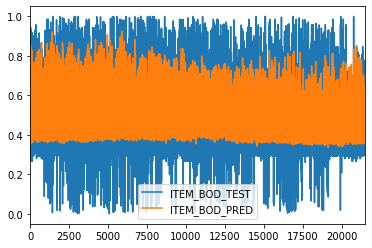

In [41]:
result.plot()